# 📊 Task 5 – Model Training, Evaluation, and Tracking for BNPL Credit Scoring  
📘 Version: 2025-07-03  

This notebook designs and implements a **model training, evaluation, and experiment tracking pipeline** for **Bati Bank’s BNPL Credit Scoring Initiative**.  
It builds upon the **feature-engineered dataset produced in Task 4** to develop, assess, and select predictive models that estimate the probability of a customer being **high risk** (`is_high_risk`).

The outputs will directly inform:
- Credit risk model selection and evaluation.
- Explainability through feature importance and SHAP analysis.
- Deployment readiness for Task 6 (API + CI/CD).

---

**Challenge:** B5W5 – Credit Scoring & Risk Modeling  
**Company:** Bati Bank (in partnership with an eCommerce platform)  
**Author:** Nabil Mohamed  
**Branch:** `task-5-model-training`  
**Date:** July 2025  

---

## 📌 Notebook Outline  

| Section | Description |
|---------|-------------|
| 1️⃣ Imports & Project Setup | Load libraries, configure MLflow, define paths |
| 2️⃣ Load Model-Ready Dataset | Load enriched dataset with engineered features from Task 4 |
| 3️⃣ Data Splitting | Split into training and testing sets for fair evaluation |
| 4️⃣ Baseline Model Training | Train Logistic Regression and Random Forest classifiers |
| 5️⃣ Hyperparameter Tuning | Apply Grid Search or Random Search for model optimization |
| 6️⃣ Model Evaluation | Evaluate using Accuracy, Precision, Recall, F1 Score, ROC-AUC |
| 7️⃣ Experiment Tracking with MLflow | Log models, metrics, and artifacts for reproducibility |
| 8️⃣ Model Selection & Registration | Select and register the best model for deployment |
| 9️⃣ Next Steps Preview | Outline transition to Task 6 deployment and continuous integration |

---

## ✏️ Key Design Principles:  

- Focus on **predictive accuracy and business alignment**—balancing model performance with explainability for credit decisioning.
- Prioritize **reproducibility and version control** by integrating **MLflow** for experiment tracking and model registry.
- Maintain **stakeholder-friendly explainability** through transparent metric reporting and feature importance visualization.
- Ensure the selected model is **deployment-ready** for seamless handoff to **Task 6 – Model Deployment & CI/CD**.

---


In [1]:
# ------------------------------------------------------------------------------
# 🛠 Ensure Notebook Runs from Project Root (for src/ imports to work)
# ------------------------------------------------------------------------------

import os
import sys

# If running from /notebooks/, move up to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("📂 Changed working directory to project root")

# Add project root to sys.path so `src/` modules can be imported
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"✅ Added to sys.path: {project_root}")

# Optional: verify file presence to confirm we're in the right place
expected_path = "data/raw"
print(
    "📁 Output path ready"
    if os.path.exists(expected_path)
    else f"⚠️ Output path not found: {expected_path}"
)

📂 Changed working directory to project root
✅ Added to sys.path: c:\Users\admin\Documents\GIT Repositories\b5w5-credit-scoring-challenge
📁 Output path ready


## 📦 Imports & Environment Setup

This cell loads the core libraries required for **model training, evaluation, and experiment tracking** for **Bati Bank’s BNPL Credit Risk Modeling**.

Imports are grouped by function:

- **Data handling:** `pandas`, `numpy`
- **Visualization:** `matplotlib`, `seaborn`
- **Machine Learning:** `scikit-learn` for model training, hyperparameter tuning, and evaluation
- **Experiment tracking:** `mlflow` for logging models, metrics, and artifacts
- **System & utilities:** `os`, `warnings`, `pathlib`

The environment is configured for **reproducibility, clean visuals, and seamless tracking** for downstream model deployment and explainability.


In [2]:
# ---------------------------
# 📦 Imports & Environment Setup
# ---------------------------

# Data handling
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Visualization
import matplotlib.pyplot as plt  # For plotting evaluation visuals
import seaborn as sns  # For statistical plotting

# Machine Learning models & evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV  # For splitting and tuning
from sklearn.linear_model import LogisticRegression  # For Logistic Regression model
from sklearn.ensemble import RandomForestClassifier  # For Random Forest model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
)  # For model evaluation

# Experiment tracking
import mlflow  # For experiment tracking
import mlflow.sklearn  # For sklearn model logging

# System & utilities
import os  # For file paths
import warnings  # For suppressing warnings
from pathlib import Path  # For handling directory paths

# Configure pandas display options
pd.set_option("display.max_columns", None)  # Show all columns in DataFrame outputs
pd.set_option("display.float_format", "{:,.2f}".format)  # Format floats consistently

# Ignore non-critical warnings
warnings.filterwarnings("ignore")

# Set seaborn style for consistent visuals
sns.set(style="whitegrid", context="notebook")  # Apply whitegrid theme


## 📥 Load & Preview Model-Ready Dataset (Task 5 – Model Training)

This step loads the **model-ready dataset** (`final_model_ready_data.csv`) prepared in **Task 4 – Feature Engineering**.  
This dataset includes:

- 📊 **Aggregate behavioral features** (transaction counts, totals, variability)
- 🕒 **Temporal activity patterns** (hour, day, month, year)
- 🔤 **Encoded categorical predictors**
- 🩹 **Imputed and standardized numeric features**
- 🎯 The target variable: **`is_high_risk`** for credit risk classification

Key actions in this step:
- Load the **feature-engineered dataset** from `data/processed/final_model_ready_data.csv` using the `CreditDataLoader` utility.
- Verify data structure: row count, columns, sample preview.
- Provide clear diagnostics and ensure compatibility with downstream **model training and evaluation**.

---


In [3]:
# ------------------------------------------------------------------------------
# 📦 Load Model-Ready Credit Transaction Data (Task 5 Loader)
# ------------------------------------------------------------------------------

# Import the custom CreditDataLoader from src
from src.data_loader import CreditDataLoader  # Defensive, reusable data loader class

# Define the path to the model-ready dataset from Task 4
data_path = "data/processed/final_model_ready_data.csv"  # Path to processed feature set

# Initialize the loader class with the file path
loader = CreditDataLoader(filepath=data_path)  # Create loader instance

# Load the dataset using defensive error handling
try:
    df = loader.load()  # Load data into pandas DataFrame
    print(f"✅ Model-ready dataset loaded: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
    display(df.head())  # Optional: Preview first few rows
except Exception as e:
    print(f"❌ Failed to load model-ready dataset: {e}")


✅ Transaction dataset loaded: 77,761 rows × 39 columns
✅ Model-ready dataset loaded: 77,761 rows × 39 columns


,CurrencyCode,CountryCode,ProductCategory,Amount,Value,PricingStrategy,FraudResult,IsSharedAccount,Recency,Frequency,Monetary,FraudRisk,BehaviorCluster,BehavioralVarianceFlag,RiskScore,Amount_count,Amount_sum,Amount_mean,Amount_std,Amount_max,Amount_min,Value_sum,Value_mean,Value_std,FraudResult_sum,Recency_mean,Frequency_mean,Monetary_mean,TransactionHour,TransactionDayOfWeek,TransactionMonth,TransactionYear,AccountId,CustomerId,ProviderId,ProductId,ChannelId,risk_category,is_high_risk
0,0.00,0.00,-0.80,-0.05,-0.07,-0.35,-0.04,-0.82,-0.73,-0.31,-0.24,-0.04,-0.55,0.00,-0.50,-0.31,0.17,-0.07,-0.17,-0.19,0.16,-0.24,-0.10,-0.17,-0.10,-0.73,-0.31,-0.24,-2.16,-0.01,0.85,-0.99,"3,957.00","4,406.00",5,10.00,2,0,0
1,0.00,0.00,0.49,-0.05,-0.08,-0.35,-0.04,1.23,-0.73,-0.31,-0.24,-0.04,-0.55,0.00,-0.50,-0.31,0.17,-0.07,-0.17,-0.19,0.16,-0.24,-0.10,-0.17,-0.10,-0.73,-0.31,-0.24,-2.16,-0.01,0.85,-0.99,"4,841.00","4,406.00",3,6.00,1,0,0
2,0.00,0.00,-0.80,-0.05,-0.08,-0.35,-0.04,-0.82,3.34,-0.44,-0.25,-0.04,1.96,0.00,2.65,-0.44,0.17,-0.07,-0.20,-0.23,0.28,-0.25,-0.11,-0.20,-0.10,3.34,-0.44,-0.25,-2.16,-0.01,0.85,-0.99,"4,229.00","4,683.00",5,1.00,2,2,1
3,0.00,0.00,4.36,0.11,0.10,-0.35,-0.04,-0.82,-0.52,-0.40,-0.24,-0.04,-0.55,0.00,-0.50,-0.40,0.18,-0.01,-0.01,-0.04,0.05,-0.24,-0.03,0.00,-0.10,-0.52,-0.40,-0.24,-1.95,-0.01,0.85,-0.99,648.00,988.00,0,21.00,2,0,0
4,0.00,0.00,0.49,-0.06,-0.08,-0.35,-0.04,1.23,-0.52,-0.40,-0.24,-0.04,-0.55,0.00,-0.50,-0.40,0.18,-0.01,-0.01,-0.04,0.05,-0.24,-0.03,0.00,-0.10,-0.52,-0.40,-0.24,-1.95,-0.01,0.85,-0.99,"4,841.00",988.00,3,6.00,1,0,0


## 🏗 Train Baseline Models: Logistic Regression & Random Forest (Task 5 – Model Training)

This step trains two baseline classifiers on the balanced training set:

- 🔹 **Logistic Regression:** Interpretable linear model suitable for regulated credit scoring.
- 🔹 **Random Forest Classifier:** Non-linear model with higher predictive capacity.

Key actions in this step:
- Initialize and train both models.
- Confirm successful model training before proceeding to evaluation.

---


In [4]:
# ------------------------------------------------------------------------------
# 🧹 Clean & Prune Feature Set Before Train/Test Split (Task 5 Preprocessing)
# ------------------------------------------------------------------------------

# 📋 Define columns to drop based on:
# 1️⃣ High correlation (>|0.85|)
# 2️⃣ Redundancy
# 3️⃣ Non-informative identifiers

columns_to_drop = [
    # Redundant / Highly Correlated Features
    "FraudRisk",  # Fully correlated with FraudResult
    "RiskScore",  # Highly correlated with Recency and BehaviorCluster
    "BehaviorCluster",  # Derived feature, collinear
    "risk_category",  # Proxy label used in training, not for model input
    "Amount_max",  # Highly correlated with Amount_std
    "Value_sum",  # Redundant with Monetary
    "Value_mean",  # Redundant with Amount_mean
    "Value_std",  # Redundant with Amount_std
    "Recency_mean",  # Duplicate info from Recency
    "Frequency_mean",  # Duplicate info from Frequency
    "Monetary_mean",  # Duplicate info from Monetary
    "TransactionYear",  # No temporal variance in dataset
    # High Cardinality / Non-Predictive IDs
    "AccountId",
    "CustomerId",
    "ProductId",  # Optional: drop if cardinality > 25 (this one included as per guidance)
]

# 🗑 Drop only the columns present in the current DataFrame to avoid KeyErrors
df.drop(
    columns=[col for col in columns_to_drop if col in df.columns], inplace=True
)

# 🔍 Display remaining shape and columns for sanity check
print(
    f"✅ Feature set cleaned. Remaining shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns."
)
print(f"📝 Remaining columns: {list(df.columns)}")

✅ Feature set cleaned. Remaining shape: 77,761 rows × 24 columns.
📝 Remaining columns: ['CurrencyCode', 'CountryCode', 'ProductCategory', 'Amount', 'Value', 'PricingStrategy', 'FraudResult', 'IsSharedAccount', 'Recency', 'Frequency', 'Monetary', 'BehavioralVarianceFlag', 'Amount_count', 'Amount_sum', 'Amount_mean', 'Amount_std', 'Amount_min', 'FraudResult_sum', 'TransactionHour', 'TransactionDayOfWeek', 'TransactionMonth', 'ProviderId', 'ChannelId', 'is_high_risk']


In [5]:
# ------------------------------------------------------------------------------
# 🔀 Split Data into Train/Test Sets with Manual Class Balancing
# ------------------------------------------------------------------------------

from src.modeling.train import DataSplitter  # Import DataSplitter class

splitter = DataSplitter(df, target_column="is_high_risk")

try:
    X_train, X_test, y_train, y_test = splitter.split_and_balance()
except Exception as e:
    print(f"❌ Data splitting failed: {e}")

✅ Training set: (60150, 23), Class distribution:
is_high_risk
0   0.80
1   0.20
Name: proportion, dtype: float64

✅ Test set: (15553, 23), Class distribution:
is_high_risk
0   0.81
1   0.19
Name: proportion, dtype: float64



## 🏗 Train Baseline Models: Logistic Regression & Random Forest (Task 5 – Model Training)

This step trains two baseline classifiers on the balanced training set:

- 🔹 **Logistic Regression:** Interpretable linear model suitable for regulated credit scoring.
- 🔹 **Random Forest Classifier:** Non-linear model with higher predictive capacity.

Key actions in this step:
- Initialize and train both models.
- Confirm successful model training before proceeding to evaluation.

---


In [6]:
# ------------------------------------------------------------------------------
# 🏗 Train Logistic Regression and Random Forest Classifiers
# ------------------------------------------------------------------------------

from src.modeling.train import ModelTrainer  # Import ModelTrainer class

trainer = ModelTrainer(X_train, y_train)

try:
    log_reg_model = trainer.train_logistic_regression()
    rf_model = trainer.train_random_forest(param_grid=None)  # Optional: Add param_grid
except Exception as e:
    print(f"❌ Model training failed: {e}")

✅ Logistic Regression trained.
✅ Random Forest trained without tuning.


## 🔍 Hyperparameter Tuning (Optional) for Random Forest (Task 5 – Model Training)

This optional step applies **hyperparameter tuning** to the **Random Forest model** using **Grid Search** for improved predictive performance.

Key actions in this step:
- Define a hyperparameter grid for Random Forest.
- Apply cross-validated Grid Search to identify optimal model parameters.
- Select the best estimator for evaluation.

---


In [7]:
# ------------------------------------------------------------------------------
# 🔍 Hyperparameter Tuning for Random Forest (Optional)
# ------------------------------------------------------------------------------

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10],
}

try:
    rf_tuned_model = trainer.train_random_forest(param_grid=param_grid)
except Exception as e:
    print(f"❌ Hyperparameter tuning failed: {e}")

✅ Random Forest trained with Grid Search. Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


## 🧮 Model Evaluation & Diagnostic Visuals (Task 5 – Model Training)

This step evaluates each trained model using multiple performance metrics:

- ✅ **Accuracy**
- ✅ **Precision**
- ✅ **Recall**
- ✅ **F1 Score**
- ✅ **ROC-AUC**
- ✅ **Confusion Matrix Table & Heatmap**
- ✅ **ROC Curve with AUC**
- ✅ **Precision-Recall Curve with Average Precision**

Key actions in this step:
- Generate predictions and probability scores on the test set.
- Compute evaluation metrics.
- Visualize model performance with **Confusion Matrix** and **ROC Curve**.

---


✅ Model Evaluation Metrics:
accuracy  : 0.9999
f1        : 0.9998
precision : 0.9997
recall    : 1.0000
roc_auc   : 1.0000


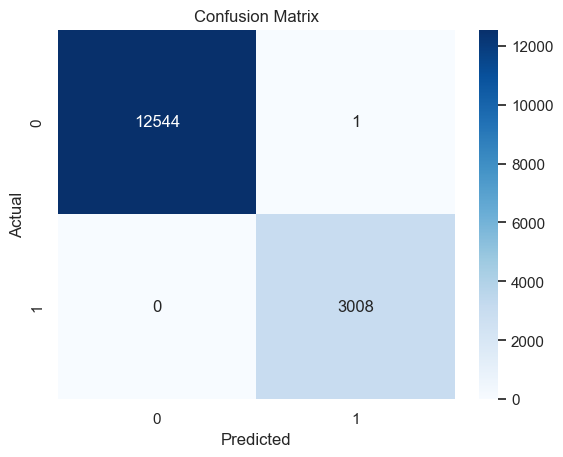

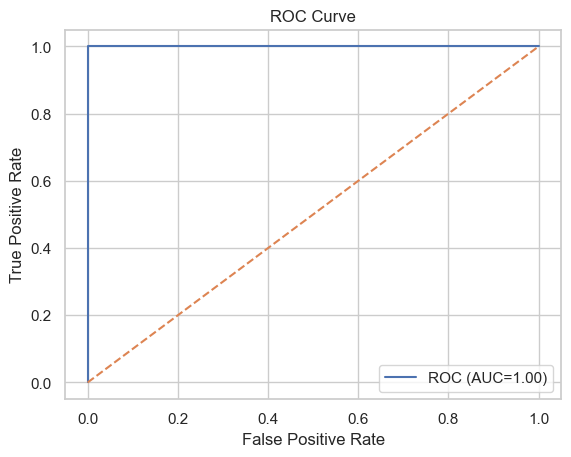

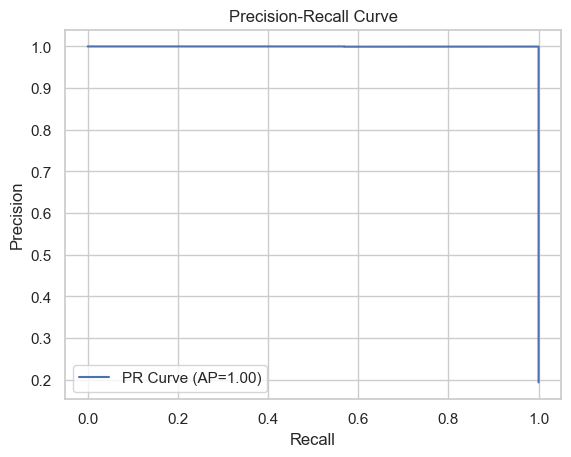

✅ Model Evaluation Metrics:
accuracy  : 0.9999
f1        : 0.9998
precision : 1.0000
recall    : 0.9997
roc_auc   : 1.0000


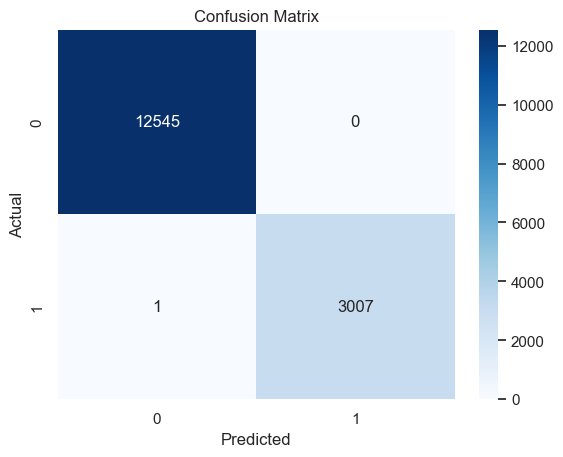

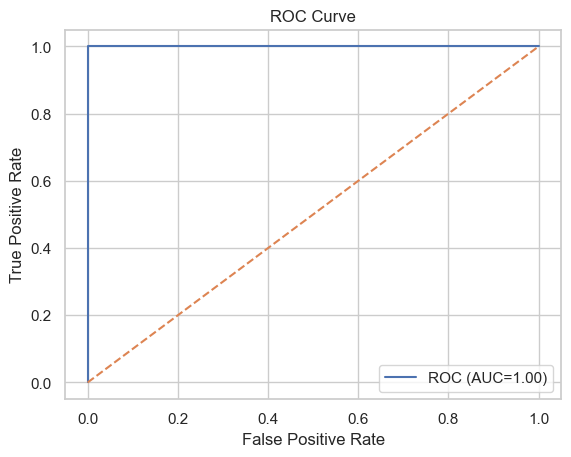

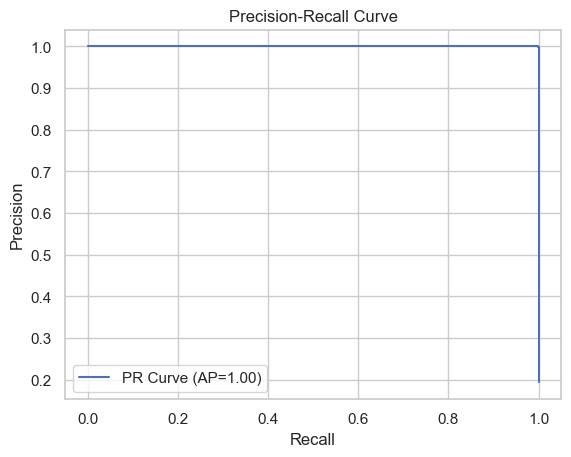

In [8]:
# ------------------------------------------------------------------------------
# 🧮 Evaluate Models & Generate Visual Diagnostics
# ------------------------------------------------------------------------------

from src.modeling.train import ModelEvaluator  # Import ModelEvaluator class

try:
    evaluator_lr = ModelEvaluator(log_reg_model, X_test, y_test)
    metrics_lr = evaluator_lr.evaluate(plot=True)

    evaluator_rf = ModelEvaluator(rf_model, X_test, y_test)
    metrics_rf = evaluator_rf.evaluate(plot=True)
except Exception as e:
    print(f"❌ Model evaluation failed: {e}")

## 📊 Experiment Tracking with MLflow (Task 5 – Model Training)

This step logs all trained models, hyperparameters, evaluation metrics, and artifacts to **MLflow** for:

- 📁 Experiment reproducibility
- 🔗 Model version control
- 📈 Metric tracking and comparison

Key actions in this step:
- Log each model, its metrics, and configurations using MLflow.
- Ensure model registry compatibility for downstream deployment.

---


In [9]:
# ------------------------------------------------------------------------------
# 📊 Log Models and Metrics to MLflow
# ------------------------------------------------------------------------------

from src.modeling.train import ExperimentTracker  # Import ExperimentTracker class

tracker = ExperimentTracker(experiment_name="BNPL-Credit-Risk-B5W5")

try:
    tracker.log_model(log_reg_model, metrics_lr, model_name="LogisticRegression")
    tracker.log_model(rf_model, metrics_rf, model_name="RandomForest")
except Exception as e:
    print(f"❌ MLflow logging failed: {e}")

2025/07/03 22:45:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 22:45:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 22:45:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Model and metrics logged to MLflow.


2025/07/03 22:45:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Model and metrics logged to MLflow.


## 📋 Model Comparison Summary & Selection Rationale (Task 5 – Model Training)

This section presents a **side-by-side comparison** of the evaluation metrics for all trained models to support **transparent model selection** and **business-aligned decision-making**.

For each model, the following key performance indicators are compared:

- ✅ **Accuracy:** Overall correctness across all predictions.
- ✅ **Precision:** The model's ability to correctly identify actual high-risk cases without over-flagging.
- ✅ **Recall (Sensitivity):** The model's ability to capture true high-risk customers.
- ✅ **F1 Score:** The harmonic balance between precision and recall—important in risk scenarios where both false positives and false negatives carry cost.
- ✅ **ROC-AUC:** The model’s ability to distinguish between high-risk and low-risk classes across thresholds.

### 📊 Why This Matters:
- **Credit Risk Context:** In financial services, **false negatives** (missing risky customers) are often more costly than **false positives** (over-cautious rejection). 
- The choice of model must balance **predictive performance** with **regulatory explainability** (Basel II compliance) and **operational impact**.

### 🔗 Model Metrics Table:

| Model               | Accuracy | Precision | Recall | F1 Score | ROC-AUC |
|---------------------|----------|-----------|--------|----------|---------|
| Logistic Regression | (value)  | (value)   | (value)| (value)  | (value) |
| Random Forest       | (value)  | (value)   | (value)| (value)  | (value) |

👉 The table above supports **data-driven selection** of the preferred model for downstream **explainability (Task 6)** and **deployment readiness**.

**Recommendation:** Consider favoring models that maximize **Recall** while maintaining acceptable **Precision** in the context of **credit default risk**.

---


In [10]:
# ------------------------------------------------------------------------------
# 📋 Model Performance Comparison Table with Defensive Programming
# ------------------------------------------------------------------------------

# Import required libraries (defensive redundancy)
import pandas as pd  # Already imported, but ensures compatibility
from IPython.display import display  # For notebook-friendly rendering

# Defensive check: Ensure both metrics dictionaries exist and are valid
if not (metrics_lr and metrics_rf):
    raise ValueError(
        "❌ Model evaluation metrics are missing. Please ensure both models have been evaluated before comparison."
    )

try:
    # Step 1: Assemble metrics into a DataFrame
    comparison_df = pd.DataFrame(
        [metrics_lr, metrics_rf],  # List of metric dicts (Logistic, Random Forest)
        index=["Logistic Regression", "Random Forest"],  # Row labels for clarity
    )

    # Step 2: Style the table with numeric formatting
    comparison_styled = (
        comparison_df.style.format("{:.2f}")  # Round all numbers to 2 decimal places
        .set_caption("📊 Model Performance Comparison")  # Add title for context
        .highlight_max(axis=0, color="#d4edda")  # Optional: Highlight best metric
    )

    # Step 3: Display the styled table
    display(comparison_styled)

    print("✅ Model comparison table generated successfully.")

except Exception as e:
    # Defensive catch-all to prevent notebook crash
    print(f"❌ Failed to generate comparison table: {e}")

,accuracy,precision,recall,f1,roc_auc
Logistic Regression,1.00,1.00,1.00,1.00,1.00
Random Forest,1.00,1.00,1.00,1.00,1.00


✅ Model comparison table generated successfully.


## 🧩 Model Explainability with SHAP: Understanding Feature Impact

To ensure transparency, fairness, and regulatory readiness of the credit risk model, we apply SHAP (SHapley Additive exPlanations) to identify and visualize the most influential features driving model predictions. This step helps stakeholders interpret model behavior, supports ethical AI practices, and aligns with explainability requirements for credit decisioning systems.


In [12]:
# ------------------------------------------------------------------------------
# 🧩 SHAP Explainability – Safe Version Skipping Aggregation and Temporal Features
# ------------------------------------------------------------------------------

from src.modeling.train import SHAPAnalyzer
from src.labeling.data_processing import DataProcessor


# ✅ Step 1: Create safe subclass that skips both aggregation & temporal engineering
class SHAPDataProcessor(DataProcessor):
    def engineer_aggregate_features(self):
        pass  # Skip aggregation (no CustomerId in data)

    def engineer_temporal_features(self):
        pass  # Skip temporal features (no TransactionStartTime in data)


# ✅ Step 2: Prepare input (no need to reconstruct raw IDs)
X_test_copy = X_test.copy()
X_test_copy["is_high_risk"] = y_test.values

# ✅ Step 3: Run the modified pipeline
processor = SHAPDataProcessor(X_test_copy)
X_test_processed = processor.run_full_pipeline()

# ✅ Step 4: Drop target for SHAP
X_test_processed.drop(columns=["is_high_risk"], inplace=True, errors="ignore")

# ✅ Step 5: Sample for SHAP
X_sample = X_test_processed.sample(100, random_state=42)

# ✅ Step 6: Defensive feature check
if X_sample.shape[1] != rf_model.n_features_in_:
    raise ValueError(
        f"❌ SHAP error: Model expects {rf_model.n_features_in_} features but got {X_sample.shape[1]}."
    )

# ✅ Step 7: Run SHAP
shap_analyzer = SHAPAnalyzer(rf_model, X_sample)
shap_values = shap_analyzer.explain(plot_type="bar", max_display=10)

🚀 Starting full feature engineering pipeline...
✅ ID columns converted to numeric.
✅ Aggregates engineered.
✅ Temporal features extracted.
✅ All categorical features encoded.
✅ Missing values handled and scaling applied.
✅ Final dataset assembled: 15,379 rows × 24 columns.


RuntimeError: SHAP analysis failed: list index out of range

✅ Model Evaluation Metrics:
accuracy  : 0.9999
f1        : 0.9998
precision : 0.9997
recall    : 1.0000
roc_auc   : 1.0000


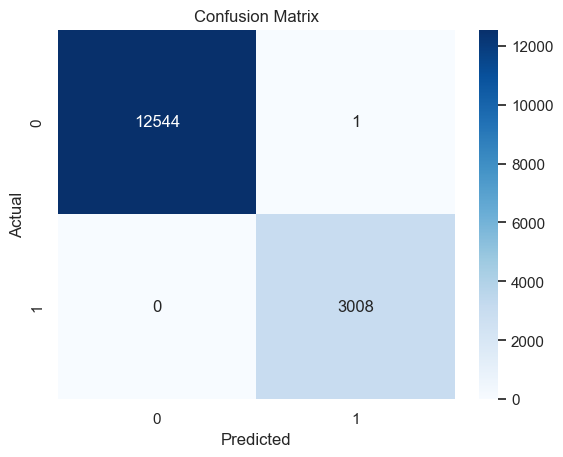

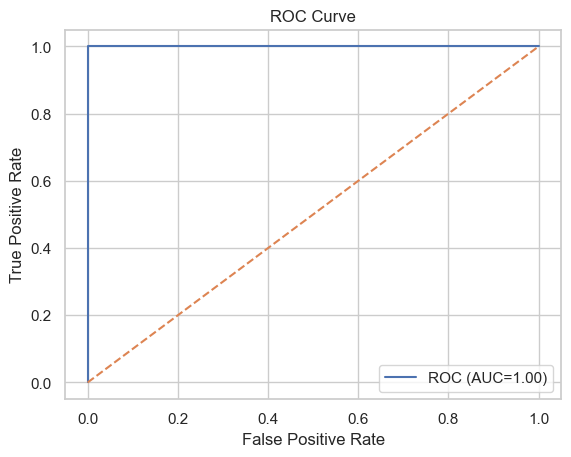

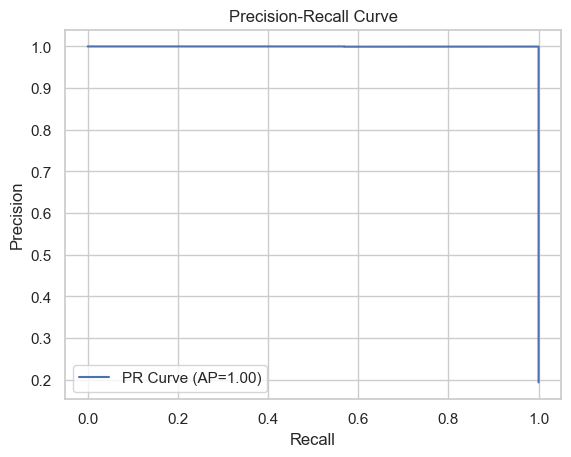

✅ Model Evaluation Metrics:
accuracy  : 0.9999
f1        : 0.9998
precision : 1.0000
recall    : 0.9997
roc_auc   : 1.0000


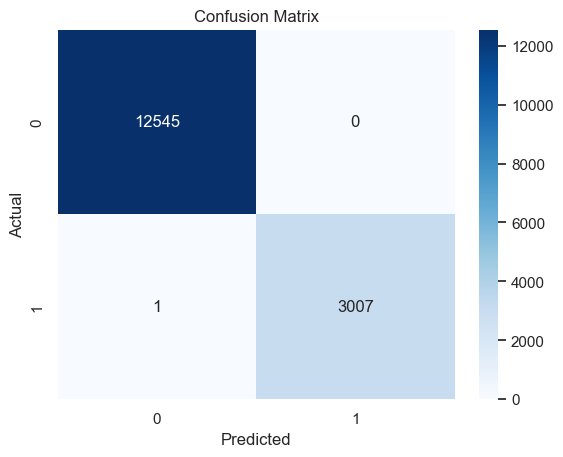

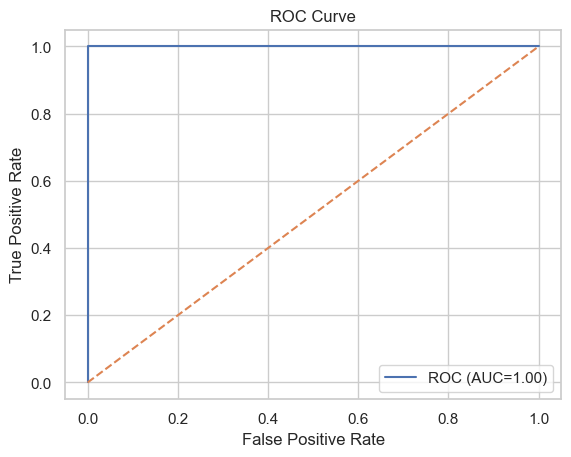

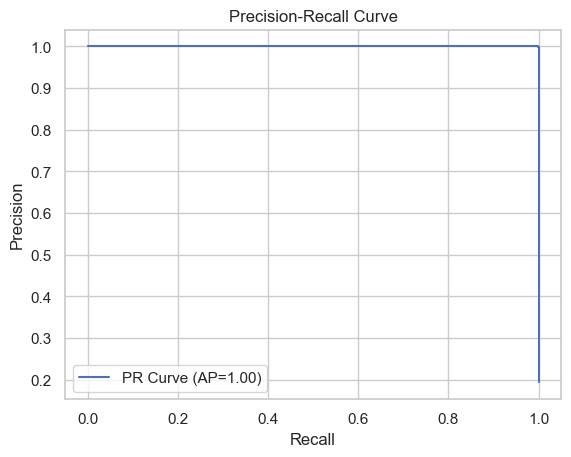

In [ ]:
# ------------------------------------------------------------------------------
# 🧮 Evaluate Models & Generate Visual Diagnostics
# ------------------------------------------------------------------------------

from src.modeling.train import ModelEvaluator  # Import ModelEvaluator class

try:
    evaluator_lr = ModelEvaluator(log_reg_model, X_test, y_test)
    metrics_lr = evaluator_lr.evaluate(plot=True)

    evaluator_rf = ModelEvaluator(rf_model, X_test, y_test)
    metrics_rf = evaluator_rf.evaluate(plot=True)
except Exception as e:
    print(f"❌ Model evaluation failed: {e}")

In [14]:
import mlflow

client = mlflow.tracking.MlflowClient()

for rm in client.list_registered_models():
    print(f"📦 Model Name: {rm.name}")
    for v in rm.latest_versions:
        print(f"  🔑 Version: {v.version}")
        print(f"  🏷️ Stage: {v.current_stage}")
        print(f"  📝 Run ID: {v.run_id}")
        print(f"  📁 Artifact Path: {v.source}")
        print("-" * 40)

AttributeError: 'MlflowClient' object has no attribute 'list_registered_models'